<img src="https://www.math24.net/wp-content/uploads/2019/02/double-pendulum1.svg" alt="drawing" width="300"/>

Using this as the model for the 2D pendulum - Note: we use $\theta$ instead of $\alpha$ to denote the angles.

In [1]:
import pickle
import sympy as sp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as ani

from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

from IPython.display import display
from IPython.display import HTML

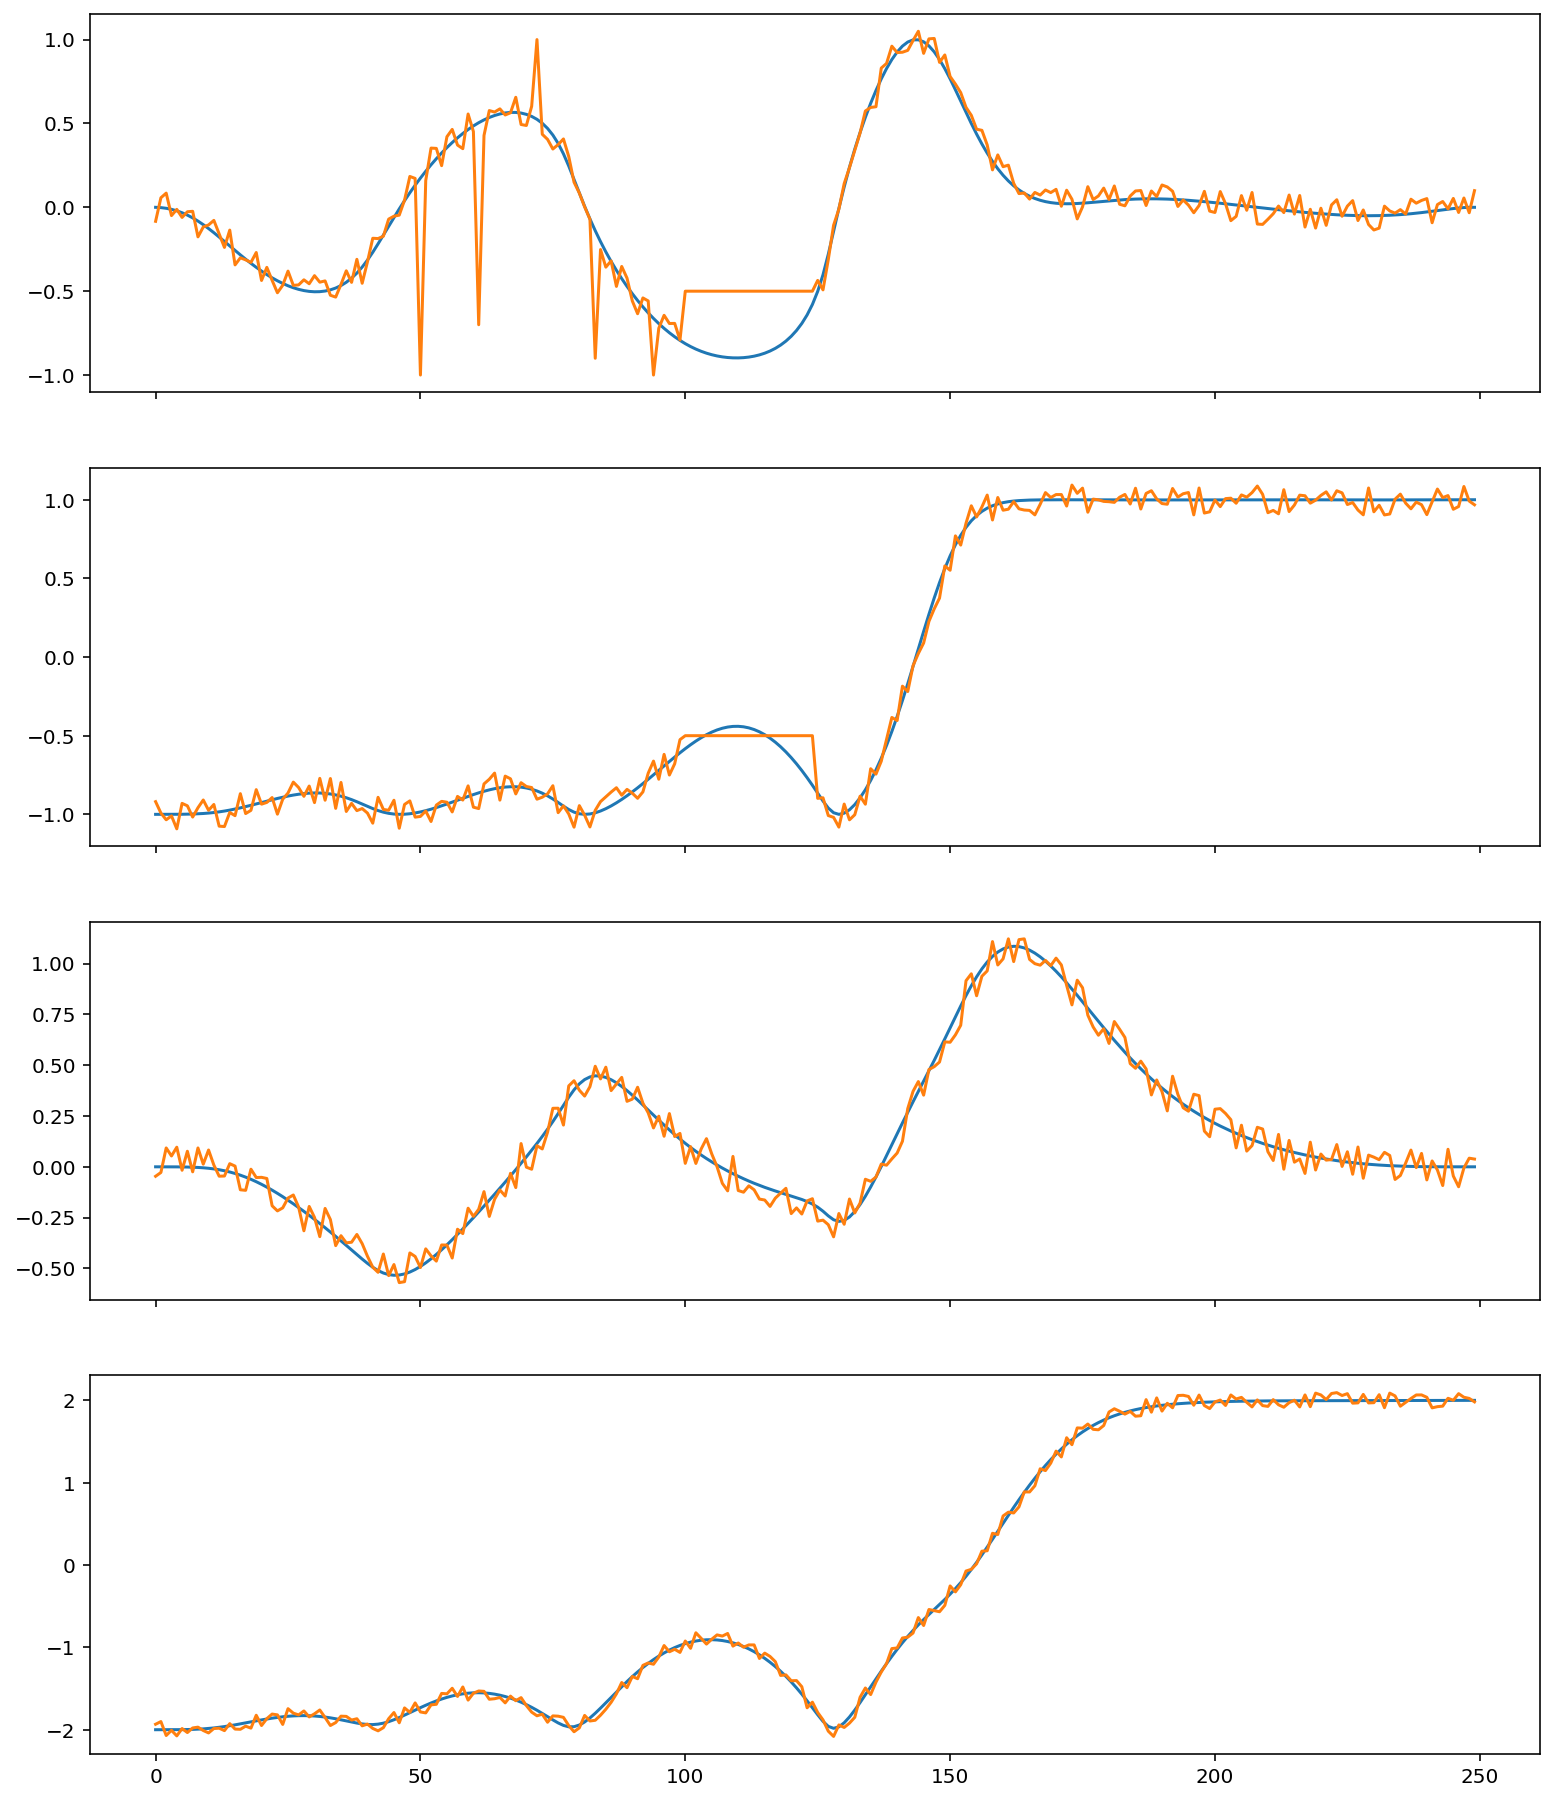

In [2]:
#LOAD IN AND PLOT MEASUREMENTS
with open("measurements.pickle", "rb") as f:
    [observed_x1, observed_y1, observed_x2, observed_y2] = pickle.load(f)

# In order to simulate real world conditions, we add noise to the measurements and
# in some instances set elements to arbitrary values (to simulate a neural net giving 
# false-positive predictions)
    
#Add noise
noise = 0.1
observed_x1_noisy = [i + np.random.uniform(-noise, noise) for i in observed_x1]
observed_x2_noisy = [i + np.random.uniform(-noise, noise) for i in observed_x2]
observed_y1_noisy = [i + np.random.uniform(-noise, noise) for i in observed_y1]
observed_y2_noisy = [i + np.random.uniform(-noise, noise) for i in observed_y2]

#Add some outlier measurements
observed_x1_noisy[50] = -1
observed_x1_noisy[61] = -0.7
observed_x1_noisy[72] = 1
observed_x1_noisy[83] = -0.9
observed_x1_noisy[94] = -1
observed_x1_noisy[105] = 1
for i in range(100,125):
    observed_x1_noisy[i] = -0.5
    observed_y1_noisy[i] = -0.5

    
    
#Plot original and noisy signals
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(13, 16), sharex=True) #create axes
ax1.plot(observed_x1)
ax1.plot(observed_x1_noisy)
ax2.plot(observed_y1)
ax2.plot(observed_y1_noisy)
ax3.plot(observed_x2)
ax3.plot(observed_x2_noisy)
ax4.plot(observed_y2)
ax4.plot(observed_y2_noisy)

In [3]:
#OUTLIER REJECTING COST FUNCTION (REDESCENDING LOSS)
def func_step(start, x):
        return 1/(1+np.e**(-10*(x - start)))

def func_piece(start, end, x):
        return func_step(start, x) - func_step(end, x)
    
def redescending_loss(err, a, b, c):
    e = abs(err)
    cost = 0.0
    cost += (1 - func_step(a, e))/2*e**2
    cost += func_piece(a, b, e)*(a*e - (a**2)/2)
    cost += func_piece(b, c, e)*(a*b - (a**2)/2 + (a*(c-b)/2)*(1-((c-e)/(c-b))**2))
    cost += func_step(c, e)*(a*b - (a**2)/2 + (a*(c-b)/2))
    return cost

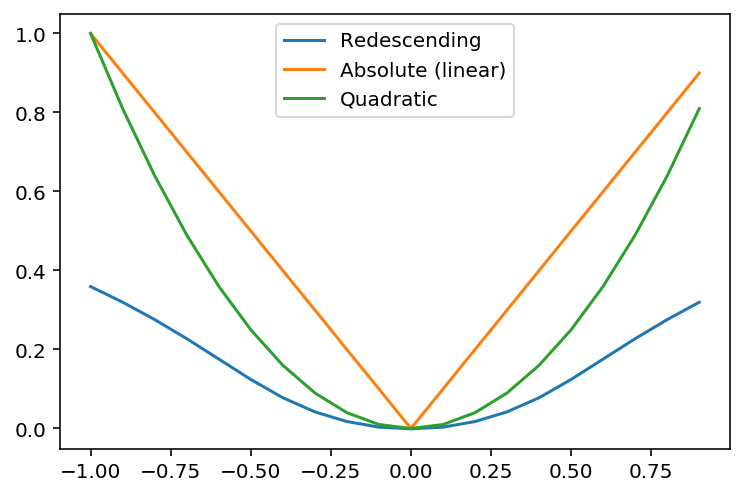

In [4]:
# PLOT OF REDESCENDING, ABSOLUTE AND QUADRATIC COST FUNCTIONS
# we use a redescending cost to stop outliers affecting the optimisation negatively

redesc_a = 0.5
redesc_b = 0.7
redesc_c = 2

#Plot
x = np.arange(-1,1,0.1)
y1 = [redescending_loss(i, redesc_a, redesc_b, redesc_c) for i in x]
y2 = abs(x)
y3 = x**2
plt.plot(x,y1, label="Redescending")
plt.plot(x,y2, label="Absolute (linear)")
plt.plot(x,y3, label="Quadratic")
ax = plt.gca()
ax.legend()

In [5]:
m = ConcreteModel(name = "Pendulum from measurements")

h = 0.02
N = 250
L = 2 #number of links
D = 2 #dimensionality of measurements (2D)

# SETS
m.N = RangeSet(N) #number of points in trajectory
m.L = RangeSet(L)
m.D = RangeSet(D)



# PARAMETERS
m.g = Param(initialize=9.81) #gravity
m.h = Param(initialize=0.02) #timestep
m.m = Param(m.L, initialize=1.0) #mass of links
m.len = Param(m.L, initialize = 1.0) #length of links



# INITIALISE MEASUREMENT DATA
def init_meas(m, n, l, d):
#     measurements = [
#         [
#             observed_x1[n-1], 
#             observed_y1[n-1]
#         ],[
#             observed_x2[n-1],
#             observed_y2[n-1]
#         ]]
    measurements = [
    [
        observed_x1_noisy[n-1], 
        observed_y1_noisy[n-1]
    ],[
        observed_x2_noisy[n-1],
        observed_y2_noisy[n-1]
    ]]
    return measurements[l-1][d-1]
m.meas = Param(m.N, m.L, m.D, initialize=init_meas)



# VARIABLES
m.th = Var(m.N, m.L)
m.dth = Var(m.N, m.L)
m.ddth = Var(m.N, m.L)
m.slack_model = Var(m.N, m.L)
m.slack_meas = Var(m.N, m.L, m.D)



# INTEGRATION CONSTRAINTS
#position
def backwards_euler_pos(m,n,l):
    if n > 1:
        return m.th[n,l] == m.th[n-1,l] + m.h*m.dth[n,l]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.L, rule = backwards_euler_pos)

#velocity
def backwards_euler_vel(m,n,l):
    if n > 1:
        return m.dth[n,l] == m.dth[n-1,l] + m.h*m.ddth[n,l]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.L, rule = backwards_euler_vel)



# CONSTANT ACCELERAION MODEL CONSTRAINTS
def model_constraint(m, n, l):
    if n > 1:
        return m.ddth[n,l] == m.ddth[n-1,l] + m.slack_model[n,l]
    else:
        return Constraint.Skip 
m.model_constraint = Constraint(m.N, m.L, rule = model_constraint)



# MEASUREMENT ERROR CONSTRAINTS
def measurement_constraint(m, n, l, d):
    x1 = m.len[1]*sin(m.th[n,1])
    y1 = -m.len[1]*cos(m.th[n,1])
    x2 = x1 + m.len[2]*sin(m.th[n,2])
    y2 = y1 - m.len[2]*cos(m.th[n,2])
    constraints = [[x1, y1], [x2, y2]]
    return constraints[l-1][d-1] - m.meas[n, l, d] - m.slack_meas[n, l, d] == 0
m.measurement_constraint = Constraint(m.N, m.L, m.D, rule = measurement_constraint)



# COST WEIGHTING APPLIED TO MODEL AND MEASUREMENTS
# model weights
m.model_err_weight = Param(initialize=1e-2)
# measurement weights
m.meas_err_weight = Param(m.N, m.L, initialize=1e2, mutable=True)
# if certain measurements are known to be bad, we can lower their weighting
# in the cost function. This is useful if we have measurements coming from a 
# neural net which have low likelihoods of being correct.
for i in range(101, 126):
    m.meas_err_weight[i,1] = 0
    m.meas_err_weight[i,2] = 0
    


# OBJECTIVE FUNCTION
def obj(m):
    slack_model_err = 0.0
    slack_meas_err = 0.0
    for n in range(1, N+1):
        for l in range(1, L+1):
            slack_model_err += m.slack_model[n, l] ** 2
            for d in range(1, D+1):
                slack_meas_err += m.meas_err_weight[n, l] * redescending_loss(m.slack_meas[n, l, d], redesc_a, redesc_b, redesc_c)
    return (slack_meas_err +
            m.model_err_weight * slack_model_err)
m.obj = Objective(rule = obj)



# INITIALISATION FOR OPTIMISATION
for n in range(1,N+1):
    for l in range(1,3):
        m.th[n,l].value = 1
        m.dth[n,l].value = 0
        m.ddth[n,l].value = 0

In [6]:
# SOLVE
opt = SolverFactory('ipopt')

# solver options
opt.options["print_level"] = 5
opt.options["max_iter"] = 30000
opt.options["max_cpu_time"] = 300
opt.options["tol"] = 1e-12

results = opt.solve(m, tee = False)

# PRINT STATUS
print("Solver status:", results.solver.status)
print("Termination condition:", results.solver.termination_condition)

Solver status: ok
Termination condition: optimal


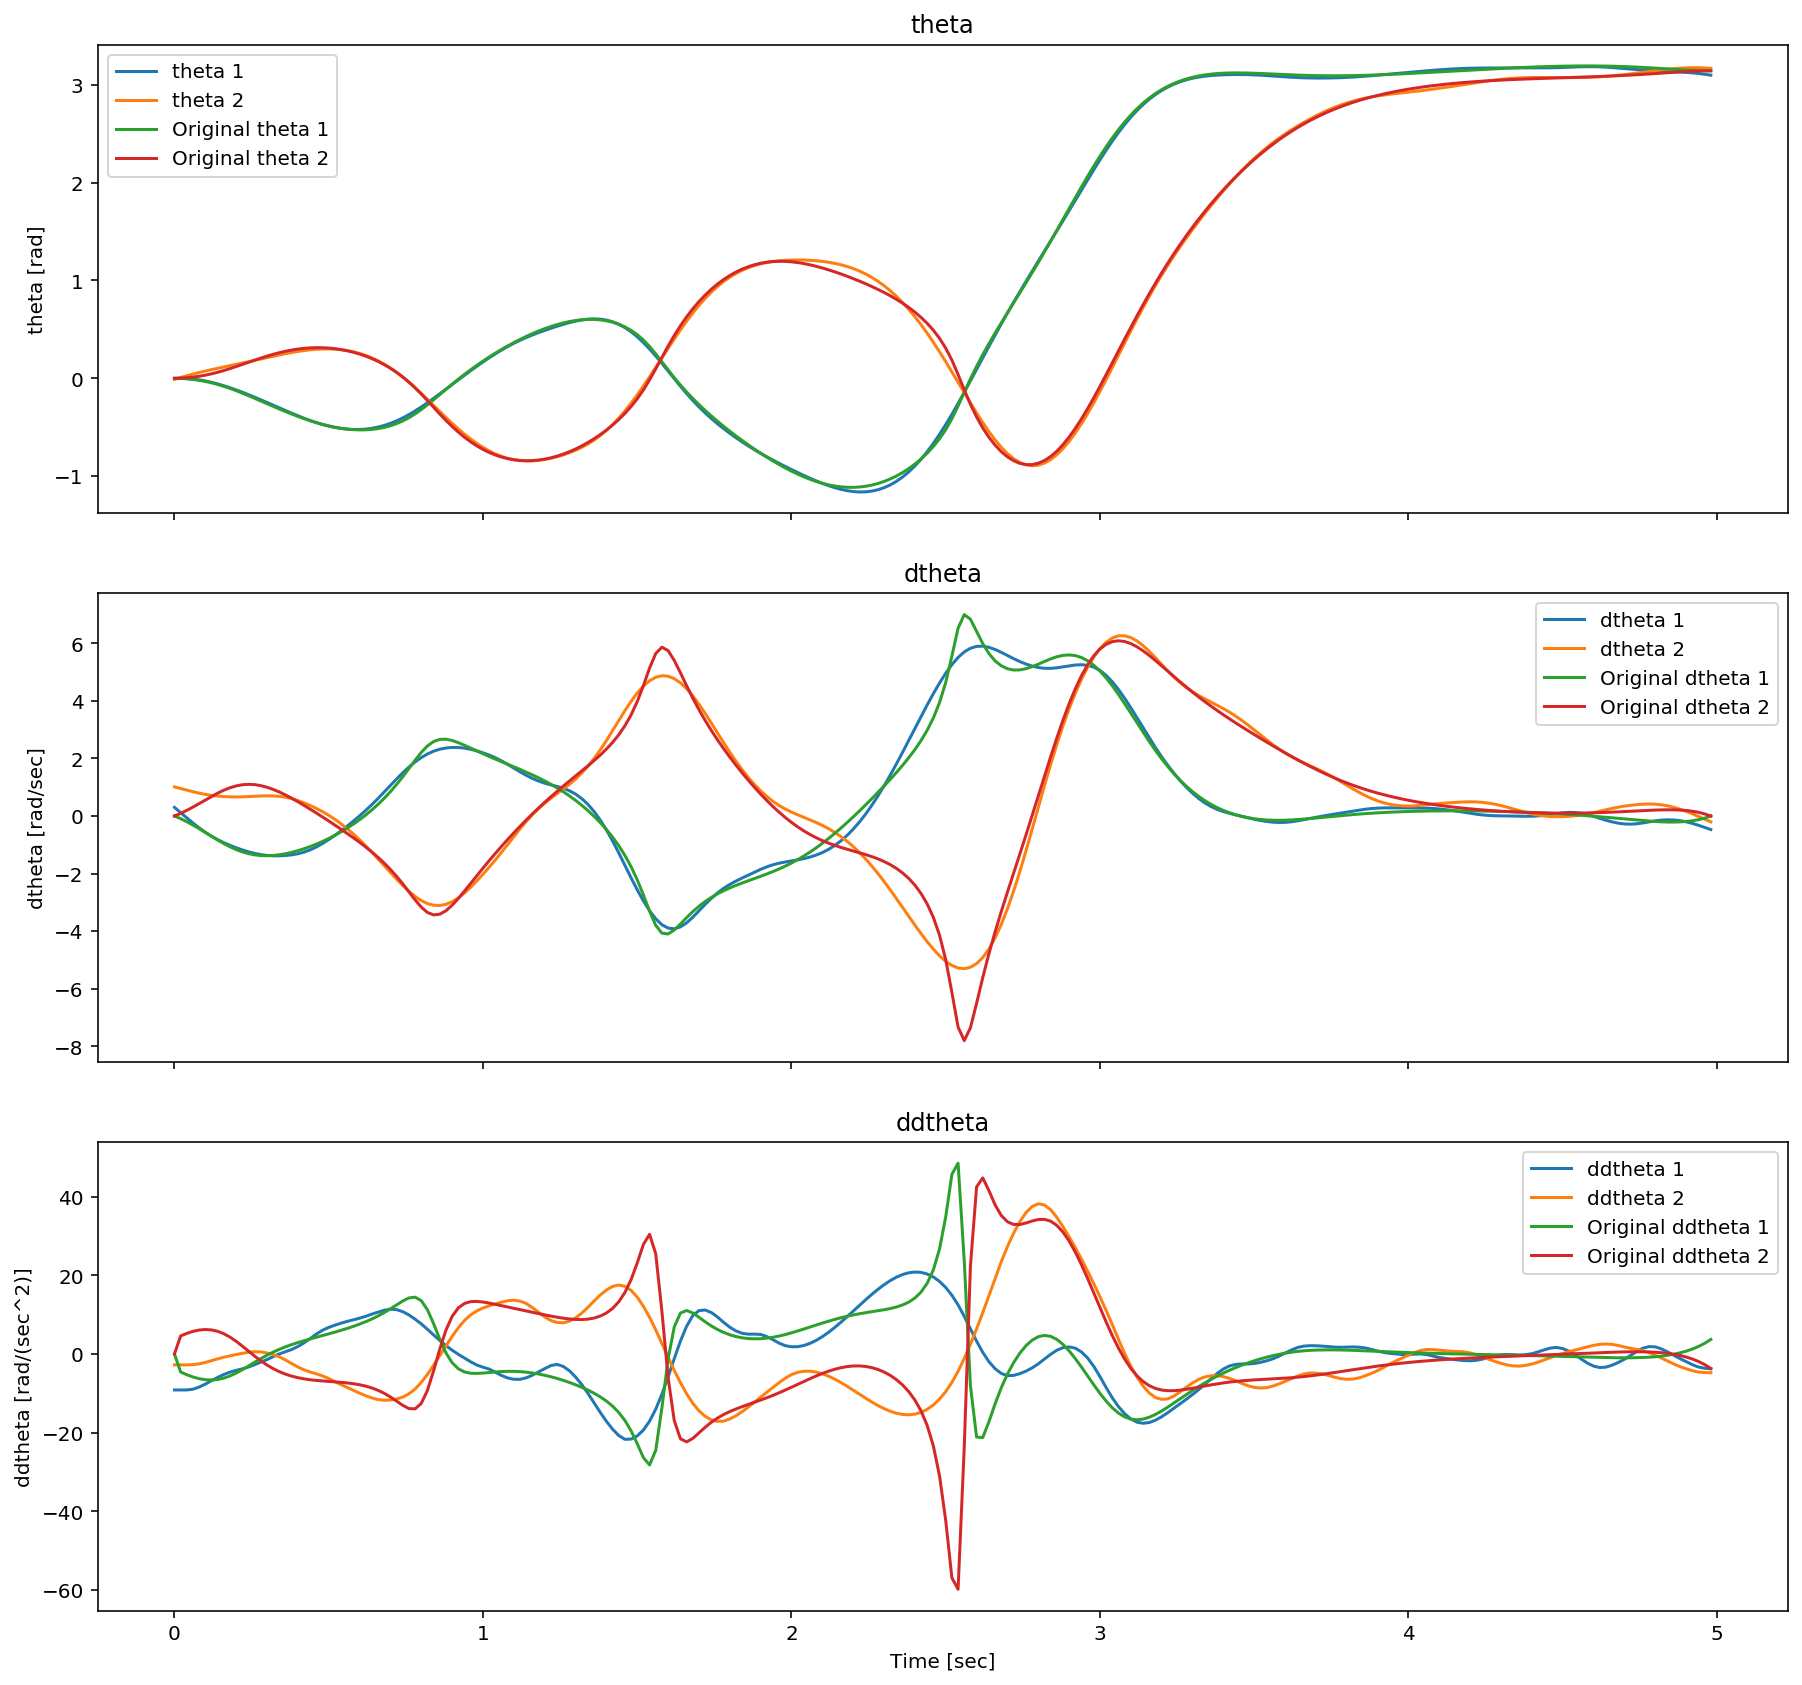

In [7]:
with open("states.pickle", "rb") as f:
    [orig_theta_1, orig_theta_2, orig_dtheta_1, orig_dtheta_2, orig_ddtheta_1, orig_ddtheta_2, orig_torque] = pickle.load(f)

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(13, 12), sharex=True) #create axes
fig.tight_layout(pad=3.0)
time = [i*h for i in range(N)]
plt.xlabel('Time [sec]')

#Pos
for i in range(1,3):
    theta = [m.th[(j, i)].value for j in range(1, N+1)]
    ax1.plot(time, theta, label=f"theta {i}")
ax1.plot(time, orig_theta_1, label="Original theta 1")
ax1.plot(time, orig_theta_2, label="Original theta 2")
ax1.set_ylabel('theta [rad]')
ax1.set_title('theta')
ax1.legend()

#Vel
for i in range(1,3):
    dtheta = [m.dth[(j, i)].value for j in range(1, N+1)]
    ax2.plot(time, dtheta, label=f"dtheta {i}")
ax2.plot(time, orig_dtheta_1, label="Original dtheta 1")
ax2.plot(time, orig_dtheta_2, label="Original dtheta 2")
ax2.set_ylabel('dtheta [rad/sec]')
ax2.set_title('dtheta')
ax2.legend()

#Acc    
for i in range(1,3):
    ddtheta = [m.ddth[(j, i)].value for j in range(1, N+1)]
    ax3.plot(time, ddtheta, label=f"ddtheta {i}")
ax3.plot(time, orig_ddtheta_1, label="Original ddtheta 1")
ax3.plot(time, orig_ddtheta_2, label="Original ddtheta 2")
ax3.set_ylabel('ddtheta [rad/(sec^2)]')
ax3.set_title('ddtheta')
ax3.legend()

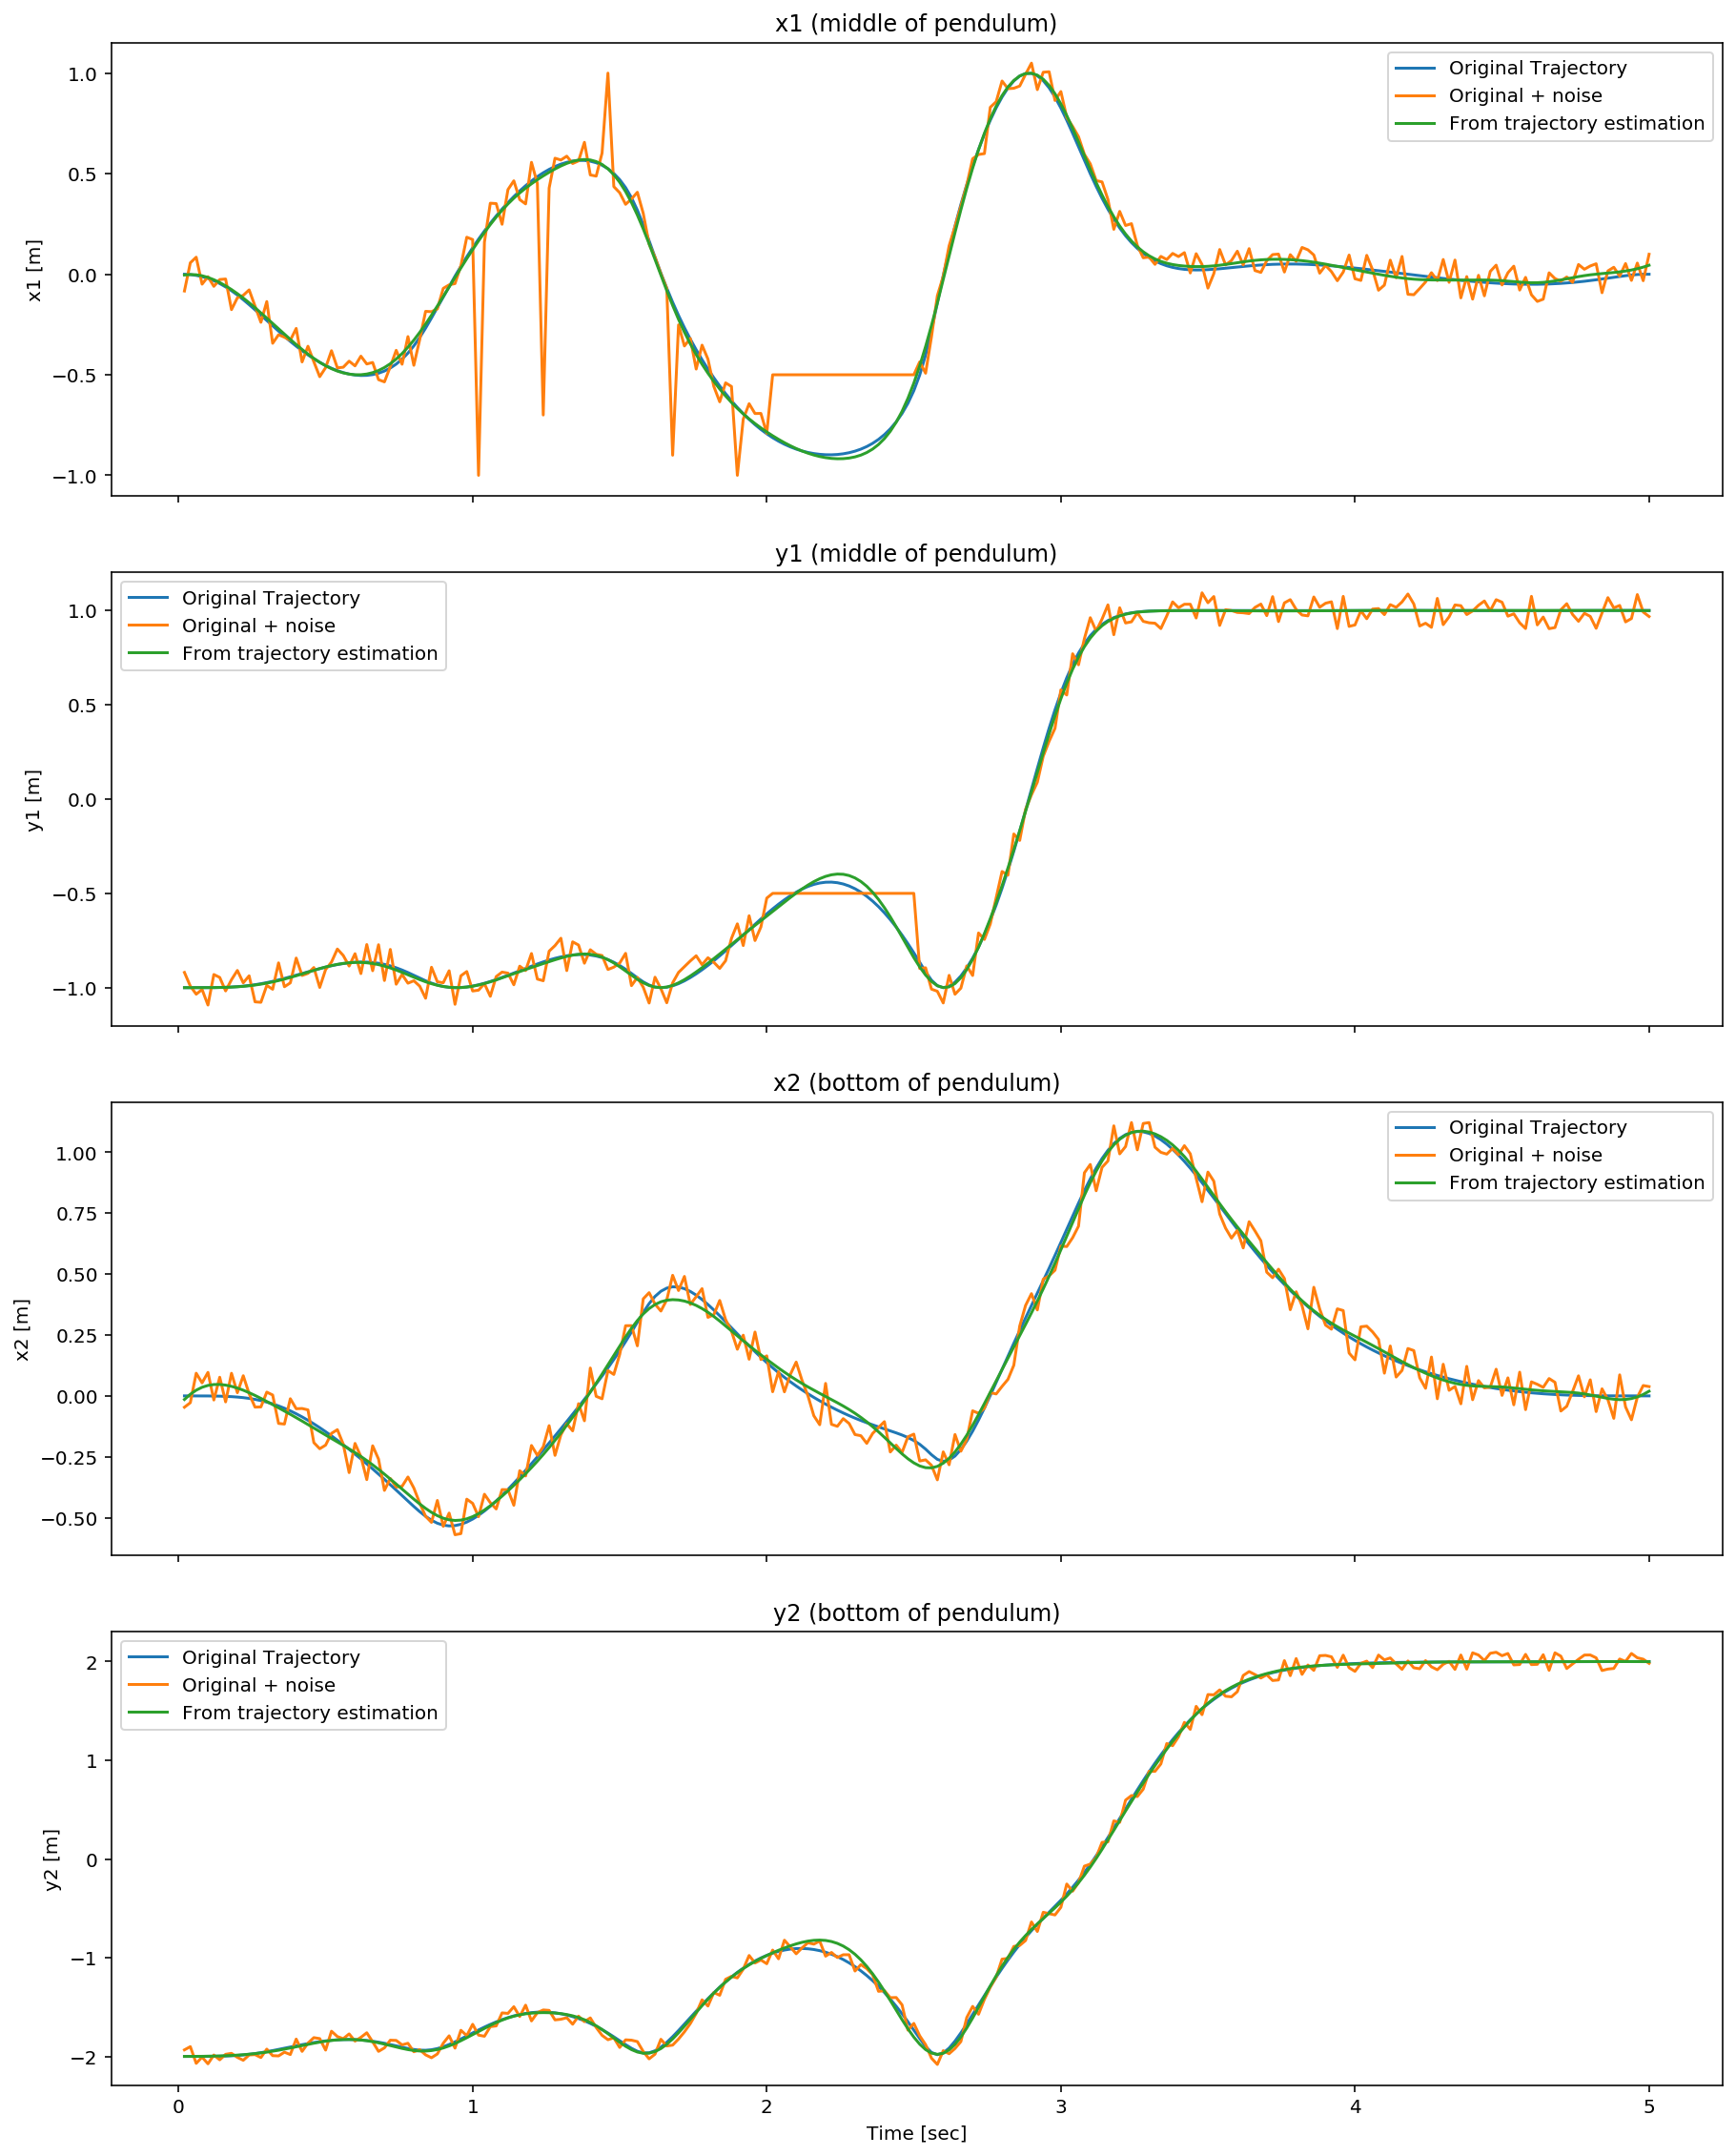

In [9]:
theta_1 = [value(m.th[(i, 1)]) for i in range(1, N+1)]
theta_2 = [value(m.th[(i, 2)]) for i in range(1, N+1)]

observed_x1_2 = value(m.len[1])*np.sin(theta_1)
observed_y1_2 = -value(m.len[1])*np.cos(theta_1)
observed_x2_2 = observed_x1_2 + value(m.len[2])*np.sin(theta_2)
observed_y2_2 = observed_y1_2 - value(m.len[2])*np.cos(theta_2)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(13, 16), sharex=True) #create axes
fig.tight_layout(pad=3.0)
time = [i*h for i in range(1, N+1)]
plt.xlabel('Time [sec]')

ax1.plot(time, observed_x1, label="Original Trajectory")
ax1.plot(time, observed_x1_noisy, label="Original + noise")
ax1.plot(time, observed_x1_2, label="From trajectory estimation")
ax1.set_ylabel('x1 [m]')
ax1.set_title('x1 (middle of pendulum)')
ax1.legend()

ax2.plot(time, observed_y1, label="Original Trajectory")
ax2.plot(time, observed_y1_noisy, label="Original + noise")
ax2.plot(time, observed_y1_2, label="From trajectory estimation")
ax2.set_ylabel('y1 [m]')
ax2.set_title('y1 (middle of pendulum)')
ax2.legend()

ax3.plot(time, observed_x2, label="Original Trajectory")
ax3.plot(time, observed_x2_noisy, label="Original + noise")
ax3.plot(time, observed_x2_2, label="From trajectory estimation")
ax3.set_ylabel('x2 [m]')
ax3.set_title('x2 (bottom of pendulum)')
ax3.legend()

ax4.plot(time, observed_y2, label="Original Trajectory")
ax4.plot(time, observed_y2_noisy, label="Original + noise")
ax4.plot(time, observed_y2_2, label="From trajectory estimation")
ax4.set_ylabel('y2 [m]')
ax4.set_title('y2 (bottom of pendulum)')
ax4.legend()

In [11]:
# ANIMATE
fig1, ax1 = plt.subplots(1,1, figsize=(10, 10))
def plot_pendulum(i, m, ax):
    ax.clear()
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    #plot top link
    L1bottomx = m.len[1]*np.sin(m.th[i, 1].value)
    L1bottomy = -m.len[1]*np.cos(m.th[i, 1].value)
    ax.plot([0,L1bottomx],[0,L1bottomy], linewidth=5, solid_capstyle='round', zorder=1)
    #plot bottom link
    L2bottomx = L1bottomx + m.len[2]*np.sin(m.th[i, 2].value)
    L2bottomy = L1bottomy - m.len[2]*np.cos(m.th[i, 2].value) 
    ax.plot([L1bottomx,L2bottomx],[L1bottomy,L2bottomy], linewidth=5, solid_capstyle='round', zorder=1)
    ax.scatter([L1bottomx,L2bottomx],[L1bottomy,L2bottomy], s=500, c='k', zorder=2)
    
update = lambda i: plot_pendulum(i, m, ax1)
animate = ani.FuncAnimation(fig1, update, range(1, N+1), interval = m.h*1000, repeat=True)
plt.close('all')
HTML(animate.to_html5_video())